In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import sys
__file__ = os.path.abspath('')
dir_path = '/'.join(os.path.realpath(__file__).split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_ez

# Loading in the DesignMatrix (and response) Data

In [5]:
df = pd.read_csv('../C39v2_sampleDesignMat.csv').drop('Unnamed: 0', axis=1).drop('index', axis=1)

# Converting photometry response to a differential rather than raw output

,grnL,grnL_diff
0,921.938,NaN
1,950.588,28.6499
2,944.091,-6.49645
3,948.262,4.17076
4,945.385,-2.87732


Text(0.5, 0, 'Timestep Index')

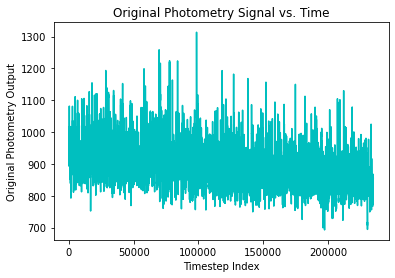

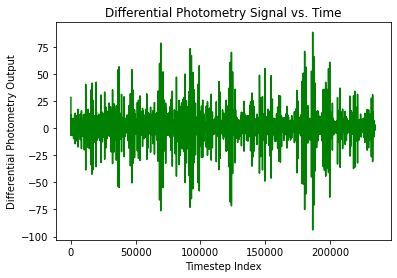

In [6]:
y_setup_col = 'grnL' # photometry response
df = sglm_ez.diff_cols(df, ['grnL'])

# Demonstrative first 5 timesteps of photometry signal vs. differential
display(df[['grnL', 'grnL_diff']].head())

# Plotting original photometry output (excluding first timestep)
plt.figure()
df['grnL'].iloc[1:].plot(color='c')
plt.title('Original Photometry Signal vs. Time')
plt.ylabel('Original Photometry Output')
plt.xlabel('Timestep Index')

# Plotting photometry differential output (excluding first timestep)
plt.figure()
df['grnL_diff'].iloc[1:].plot(color='g')
plt.title('Differential Photometry Signal vs. Time')
plt.ylabel('Differential Photometry Output')
plt.xlabel('Timestep Index')

# Specifying columns to retain for GLM fitting

In [7]:
X_cols = [
    'nTrial', # trial ID
    'iBlock', # block number within session
    'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1) # Keep
    'ENLPenalty', # lick during ENL period (no directionality yet, 0,1) # Keep
    'Select', # binary selection lick
    'Consumption', # consumption period (from task perspective)
    'TO', # timeout trial
    'responseTime', # task state cue to selection window
    'ENL', # task state ENL window
    'Cue', # task state Cue window # Keep (and all after)
    'decision', # choice lick direction (aligned to select but with directionality -1,1)
    'switch', # switch from previous choice on selection (-1,1)
    'selR', # select reward (-1,1) aligned to selection
    'selHigh', # select higher probability port (-1,1)
    'Reward', # reward vs no reward during consumption period (-1,1)
    'post', # log-odds probability
]

y_col = 'grnL_diff'

In [10]:
# plt.plot(X_setup['post'].iloc[:20000])
# plt.ylim

# Keep only relevant columns specified above

In [11]:
dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1


# Timeshift all non-response columns forward and backward ts timesteps

In [12]:

dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[2:], neg_order=-10, pos_order=10)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[2:], neg_order=-10, pos_order=10)
# X_setup = sglm_ez.diff_cols(X_setup, ['A', 'B'])
# X_setup = sglm_ez.setup_autoregression(X_setup, ['B'], 4)

dfrel = dfrel.dropna()


In [13]:
X_setup = dfrel[X_cols]
# X_setup = dfrel[X_cols_sftd]
y_setup = dfrel[y_col]

X_setup.head()

,nTrial,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

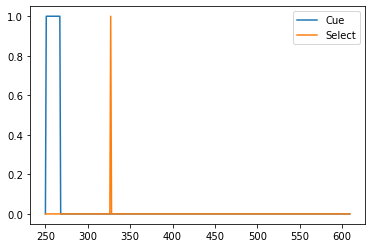

In [42]:
X_setup.iloc[240:600, [9, 4]].plot() # Make this tone one point — make it binned (one and only one point) — use tone duration as binning factor, then make it look like a delta function
# Data has to be collapsed based on when tone starts

In [ ]:
# Sum of values in binning windows

In [32]:
X_setup.groupby(['nTrial']).count()

,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post
nTrial,,,,,,,,,,,,,,,
4.0,944,944,944,944,944,944,944,944,944,944,944,944,944,944,944
5.0,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151
6.0,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168
7.0,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118
8.0,988,988,988,988,988,988,988,988,988,988,988,988,988,988,988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235.0,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033
236.0,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080
237.0,991,991,991,991,991,991,991,991,991,991,991,991,991,991,991


In [43]:
# # investigate_X = X_setup[[_ for _ in X_setup.columns if _ not in ['nTrial', 'iBlock', 'TO', 'Select', 'Consumption', 'selHigh']]]
# # (investigate_X.corr()-np.eye(investigate_X.shape[1])).abs().max(axis=1)

# from sklearn.decomposition import PCA
# pca = PCA()
# X_setup_pca = pca.fit_transform(X_setup[[_ for _ in X_setup.columns if _ != 'TO']].iloc[:, 2:])



In [67]:
%matplotlib inline
# plt.plot(pca.explained_variance_[1:])
pca.explained_variance_.min()

4.255924898971977e-06

In [68]:
pd.DataFrame(X_setup).corr()

,nTrial,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post
nTrial,1.000000,0.996441,-4.264678e-06,0.001474,0.000167,0.006702,NaN,-0.020782,0.002214,0.000694,5.552620e-04,0.000109,-0.000364,-0.001159,-0.009860,-0.019173
iBlock,0.996441,1.000000,2.559368e-04,0.001944,0.000148,0.005934,NaN,-0.020874,0.002540,0.000635,5.063026e-04,0.000506,-0.000760,-0.001692,-0.020557,-0.019497
CuePenalty,-0.000004,0.000256,1.000000e+00,-0.000014,-0.000065,-0.002624,NaN,-0.000454,-0.001378,0.015642,-5.542135e-07,0.000053,-0.000033,-0.000043,-0.000900,-0.001529
ENLPenalty,0.001474,0.001944,-1.411918e-05,1.000000,-0.000217,-0.008701,NaN,-0.001505,0.010245,-0.000903,-1.838157e-06,0.000177,-0.000110,-0.000142,-0.002984,-0.005070
Select,0.000167,0.000148,-6.543007e-05,-0.000217,1.000000,-0.040323,NaN,0.144158,-0.021182,-0.004183,8.470319e-03,-0.813421,0.508285,0.652354,-0.013827,-0.023497
Consumption,0.006702,0.005934,-2.623523e-03,-0.008701,-0.040323,1.000000,NaN,-0.279718,-0.849339,-0.167718,-3.415528e-04,0.032800,-0.020496,-0.026305,0.342906,0.582710
TO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
responseTime,-0.020782,-0.020874,-4.538786e-04,-0.001505,0.144158,-0.279718,NaN,1.000000,-0.146939,0.007915,1.221061e-03,-0.117261,0.073273,0.094042,-0.095917,-0.162995
ENL,0.002214,0.002540,-1.378162e-03,0.010245,-0.021182,-0.849339,NaN,-0.146939,1.000000,-0.071255,-1.794211e-04,0.017230,-0.010767,-0.013818,-0.291244,-0.494919
Cue,0.000694,0.000635,1.564244e-02,-0.000903,-0.004183,-0.167718,NaN,0.007915,-0.071255,1.000000,-3.543011e-05,0.003402,-0.002126,-0.002729,-0.057512,-0.097731


In [69]:
(pd.DataFrame(X_setup).corr() - np.eye(X_setup.shape[1])).abs().max(axis=1)

nTrial          0.996441
iBlock          0.996441
CuePenalty      0.015642
ENLPenalty      0.010245
Select          0.813421
Consumption     0.849339
TO                   NaN
responseTime    0.279718
ENL             0.849339
Cue             0.167718
decision        0.016958
switch          0.813421
selR            0.788073
selHigh         0.788073
Reward          0.342906
post            0.582710
dtype: float64

In [70]:
pd.DataFrame(X_setup_pca).corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000e+00,4.767807e-14,2.591267e-14,-1.051512e-14,-4.265347e-15,-4.765608e-16,1.148037e-16,-9.239807e-16,2.079859e-16,-1.347372e-16,3.525909e-16,5.365912e-16,-8.718464e-16
1,4.767807e-14,1.000000e+00,2.536037e-14,-2.968663e-14,3.037916e-15,-1.172266e-15,-1.819123e-16,1.349071e-16,-5.285429e-17,-5.090020e-17,1.338428e-16,5.787232e-16,-9.730591e-17
2,2.591267e-14,2.536037e-14,1.000000e+00,1.557195e-14,-6.728682e-15,-8.775566e-15,-2.365860e-15,-2.117729e-15,1.443398e-15,-1.544433e-15,1.387770e-15,1.708960e-16,1.068049e-15
3,-1.051512e-14,-2.968663e-14,1.557195e-14,1.000000e+00,-1.853405e-15,9.192398e-15,-6.834443e-16,3.108389e-15,-3.481977e-15,2.152574e-15,-1.021691e-14,-2.086777e-16,-8.492106e-16
4,-4.265347e-15,3.037916e-15,-6.728682e-15,-1.853405e-15,1.000000e+00,8.818324e-17,4.420880e-15,1.612262e-15,2.895327e-15,1.609178e-15,3.504251e-15,2.798270e-17,-1.510595e-15
5,-4.765608e-16,-1.172266e-15,-8.775566e-15,9.192398e-15,8.818324e-17,1.000000e+00,3.116489e-15,-6.193028e-15,-1.231201e-15,7.160451e-16,1.300227e-16,-2.203255e-17,1.516959e-15
6,1.148037e-16,-1.819123e-16,-2.365860e-15,-6.834443e-16,4.420880e-15,3.116489e-15,1.000000e+00,-4.979501e-16,-1.565976e-15,1.081056e-15,9.949170e-15,-6.539900e-17,-4.761761e-19
7,-9.239807e-16,1.349071e-16,-2.117729e-15,3.108389e-15,1.612262e-15,-6.193028e-15,-4.979501e-16,1.000000e+00,9.090786e-14,1.667022e-14,7.680097e-15,7.676355e-17,-3.116062e-18
8,2.079859e-16,-5.285429e-17,1.443398e-15,-3.481977e-15,2.895327e-15,-1.231201e-15,-1.565976e-15,9.090786e-14,1.000000e+00,-3.423329e-14,5.217926e-14,2.581366e-16,-9.546217e-18
9,-1.347372e-16,-5.090020e-17,-1.544433e-15,2.152574e-15,1.609178e-15,7.160451e-16,1.081056e-15,1.667022e-14,-3.423329e-14,1.000000e+00,1.739455e-14,-1.334569e-16,-1.218570e-17


In [71]:
X_setup.describe()

,nTrial,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post
count,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.0,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000
mean,121.140847,6.577320,0.000004,0.000047,0.001005,0.617859,0.0,0.046158,0.308517,0.017100,0.000009,-0.000817,0.000511,0.000656,0.314166,0.315232
std,68.141723,3.407471,0.002063,0.006843,0.031680,0.485912,0.0,0.209829,0.461882,0.129646,0.031696,0.031686,0.031692,0.031689,0.720528,0.425447
min,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,62.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,121.000000,7.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018520
75%,180.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.881418
max,239.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988810


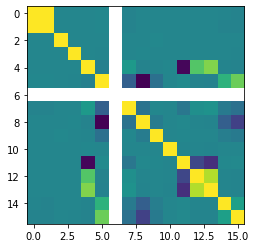

In [72]:
plt.imshow(X_setup.corr())

# Drop first column due to response "diff" and all NA columns generated from timeshifts

In [ ]:
glm = sglm_ez.fit_GLM(X_setup, y_setup, reg_lambda=0.1)
pred = glm.predict(X_setup)
mse = np.mean((y_setup - pred)**2)

In [95]:
glm = sglm.GLM('Gaussian')
glm.pca_fit(X_setup, y_setup.values)

In [96]:
glm.beta_

array([ 4.15131916e-06, -2.23921440e-02, -1.01667706e-02,  3.46978795e-01,
        6.82616635e-02,  1.02869577e+00, -7.74593087e-01,  4.34569518e-01,
       -8.28056639e-01, -4.02251531e-01, -8.93610857e-01, -6.43801797e-01,
       -1.26480046e+00, -3.42736604e-01, -1.55680115e+00, -3.45321881e-01])

In [118]:
glm.pca.transform(X_setup)

array([[-1.17273202e+02, -9.02839965e-01, -4.75261508e-01, ...,
        -1.69647091e-04, -5.10113893e-06, -1.65196562e-17],
       [-1.17273202e+02, -9.02839965e-01, -4.75261508e-01, ...,
        -1.69647091e-04, -5.10113893e-06, -1.65196562e-17],
       [-1.17273202e+02, -9.02839965e-01, -4.75261508e-01, ...,
        -1.69647091e-04, -5.10113893e-06, -1.65196562e-17],
       ...,
       [ 1.17983054e+02, -4.55453018e-01,  1.39797303e+00, ...,
         5.50751989e-05,  1.19451304e-05, -1.83037290e-17],
       [ 1.17983054e+02, -4.55453018e-01,  1.39797303e+00, ...,
         5.50751989e-05,  1.19451304e-05, -1.83037290e-17],
       [ 1.17983017e+02, -4.51563102e-01, -8.30647753e-02, ...,
         4.28423699e-05, -2.35942932e-05, -6.36115477e-17]])

In [122]:
(X_setup - glm.pca.mean_) @ glm.pca.components_.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
10,-117.273202,-0.902840,-0.475262,-0.149602,-0.268302,-0.071608,-0.017517,0.004963,0.000243,0.000049,0.000005,-0.000035,-0.000056,-0.000170,-0.000005,-1.651966e-17
11,-117.273202,-0.902840,-0.475262,-0.149602,-0.268302,-0.071608,-0.017517,0.004963,0.000243,0.000049,0.000005,-0.000035,-0.000056,-0.000170,-0.000005,-1.651966e-17
12,-117.273202,-0.902840,-0.475262,-0.149602,-0.268302,-0.071608,-0.017517,0.004963,0.000243,0.000049,0.000005,-0.000035,-0.000056,-0.000170,-0.000005,-1.651966e-17
13,-117.273202,-0.902840,-0.475262,-0.149602,-0.268302,-0.071608,-0.017517,0.004963,0.000243,0.000049,0.000005,-0.000035,-0.000056,-0.000170,-0.000005,-1.651966e-17
14,-117.273202,-0.902840,-0.475262,-0.149602,-0.268302,-0.071608,-0.017517,0.004963,0.000243,0.000049,0.000005,-0.000035,-0.000056,-0.000170,-0.000005,-1.651966e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234913,117.983054,-0.455453,1.397973,-0.326189,0.548428,-0.000963,-0.006193,-0.000231,-0.000658,-0.000061,0.000078,0.000059,0.000170,0.000055,0.000012,-1.830373e-17
234914,117.983054,-0.455453,1.397973,-0.326189,0.548428,-0.000963,-0.006193,-0.000231,-0.000658,-0.000061,0.000078,0.000059,0.000170,0.000055,0.000012,-1.830373e-17
234915,117.983054,-0.455453,1.397973,-0.326189,0.548428,-0.000963,-0.006193,-0.000231,-0.000658,-0.000061,0.000078,0.000059,0.000170,0.000055,0.000012,-1.830373e-17
234916,117.983054,-0.455453,1.397973,-0.326189,0.548428,-0.000963,-0.006193,-0.000231,-0.000658,-0.000061,0.000078,0.000059,0.000170,0.000055,0.000012,-1.830373e-17


In [145]:
glm.predict(glm.pca.transform(X_setup))

array([-0.10406184, -0.10406184, -0.10406184, ..., -0.07574853,
       -0.07574853,  0.02038292])

In [134]:
glm.pca.mean_.shape

(16, 1)

In [144]:
W = glm.pca.components_.T
B = glm.beta_.reshape([-1, 1])
B0 = glm.beta0_
X_bar = glm.pca.mean_

X_setup @ (W @ B) - (X_bar @ W @ B) + B0

,0
10,-0.104062
11,-0.104062
12,-0.104062
13,-0.104062
14,-0.104062
...,...
234913,-0.075749
234914,-0.075749
234915,-0.075749
234916,-0.075749


In [ ]:
kfold_cv_idx = sglm_ez.cv_idx_by_trial_id(X_setup, y=y_setup, trial_id_columns=['nTrial', 'iBlock'])

# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    # 'reg_lambda': [0.0001],
    'reg_lambda': [0.001, 0.01, 0.1, 1.0],
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'fit_intercept': [True, False]
}


# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'max_iter': 1000
}

# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)
best_score, best_params, best_model = sglm_ez.simple_cv_fit(X_setup, y_setup, kfold_cv_idx, glm_kwarg_lst, model_type='Normal')

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:734: RuntimeWarning: divide by zero encountered in double_scalars
  update = 1. / hk * gk
/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:734: RuntimeWarning: invalid value encountered in double_scalars
  update = 1. / hk * gk
/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


In [1]:
X_setup.corr()

NameError: name 'df' is not defined

In [ ]:
X_setup.describe()

In [ ]:
print('test')

# Fit GLM with predictors X and response y

## SKLearn-based Implementation (No Cross-Validation)

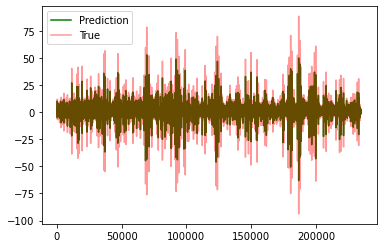

In [ ]:

glm3 = sglm.SKGLM('Normal', max_iter=10000, alpha=0)
glm3.fit(X.values[1:], y.values[1:])

pred = glm3.model.predict(X.values)
true = y.values

# plt.plot(pred[:1000], color='g')
# plt.plot(true[:1000], alpha = 0.4, color='r')
plt.plot(pred[:], color='g', label='Prediction')
plt.plot(true[:], alpha = 0.4, color='r', label='True')
plt.legend()

In [ ]:
print('Stats Model AIC')
import statsmodels.api as sm
X2 = sm.add_constant(X)
srl = sm.OLS(y, X2)
results = srl.fit()
results.aic

# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/linear_model.py#L1822

# Difference caused by SKLearn's tolerance parameter in fitting descent process

# llf = glm3.log_likelihood(pred, true)
# df_modelwc = X.shape[-1] + 1
# nobs = X.shape[0] - 1

pred_sm = results.predict(X2)
print('Stats Model Fit — Log Likelihood:', results.llf)
print('Stats Model Fit — By Hand Log Likelihood:', glm3.log_likelihood(pred_sm, true))


print('AIC by Hand:', 2*(X.shape[-1] + 1) - 2*glm3.log_likelihood(pred, true))
# # print(-2.0 * llf + 2.0 * df_modelwc * nobs / (nobs - df_modelwc - 1.0))
# print(np.std(true - pred) + (-2.0 * llf + 2.0 * df_modelwc) / nobs)
# print(-2.0 * llf + 2.0 * df_modelwc * nobs / (nobs - df_modelwc - 1.0))

print('Stats Model AIC', results.aic)



Stats Model AIC
Stats Model Fit — Log Likelihood: -426357.18136291485
Stats Model Fit — By Hand Log Likelihood: -426357.1813629149
AIC by Hand: 852882.668637965
Stats Model AIC 852870.3627258297


In [ ]:
glm4 = sglm.SKGLM('Logistic', max_iter=10000, C=100000000)
glm4.fit(X.values[:,:6], y.values[:] > 0)

pred4 = glm4.model.predict_proba(X.values[:,:6])[:,1]
true4 = y.values > 0


# glm4.log_likelihood(pred4, true4)
# np.sum(true4 * np.log(pred4) + (1-true4)*np.log(1-pred4))

import statsmodels.api as sm
X2 = sm.add_constant(X.iloc[:,:6])
srl = sm.Logit(y > 0, X2)
results = srl.fit()

print()

print('AIC by Hand:', 2*(X.values[:,:6].shape[-1] + 1) - 2*glm4.log_likelihood(pred4, true4))
print('Stats Model AIC', results.aic)

# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/linear_model.py#L1822

Optimization terminated successfully.
         Current function value: 0.679118
         Iterations 13

AIC by Hand: 319096.43313799205
Stats Model AIC 319092.052636612


## Running Cross-Validation for Parameter Selection

In [ ]:
# Examine Keyword Parameters for Tweedie Regression (upon which SKGLM is based):
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html

# For demonstration, let's cross validate L2 regularization strength "alpha", whether or not to
# "fit_intercept", and do both of these with a fixed 'link'='auto' and a larger fixed
# max iteration number, "max_iter"

In [ ]:
# Step 1: Create time buckets of 1000 entries each (actual value will vary based on
# sampling rate and amount of time desired for bucketing)
num_buckets = X.shape[0] // 1000
print('Num Buckets:', num_buckets)

slice_ids = np.arange(X.shape[0]) // num_buckets
print('Slice IDs:', slice_ids)

Num Buckets: 234
Slice IDs: [   0    0    0 ... 1003 1003 1003]


In [ ]:
# Step 2: Create index sets for each of the K-folds based on prior groupings
splitter = GroupShuffleSplit(n_splits=5)
cv_idx = list(splitter.split(X, y, slice_ids))

In [ ]:
# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}

# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'link': 'auto',
    'max_iter': 1000
}

# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

display(glm_kwarg_lst)

[{'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': False},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': False},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': False},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': False}]

In [ ]:
# Step 4: Fit GLM models for all possible sets of values
cv_results = sglm_cv.cv_glm_mult_params(X.values,
                                        y.values,
                                        cv_idx,
                                        'Normal',
                                        glm_kwarg_lst,
                                        GLM_CLS=sglm.SKGLM,
                                        verbose=1)

best_score = cv_results['best_score']
best_params = cv_results['best_params']

Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': False}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': False}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': False}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': False}


In [ ]:
print(f"Best Score: {best_score} — Given By: {best_params}")

Best Score: 0.601 — Given By: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': False}


In [ ]:
np.isnan(y.values).sum()

0

## Pyglmnet-based Implementation — (Needs debuggging)

Example Predictions: [-0.00052633 -0.00052633 -0.00052633 ... -0.00052633 -0.00052633
 -0.00052633]


/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


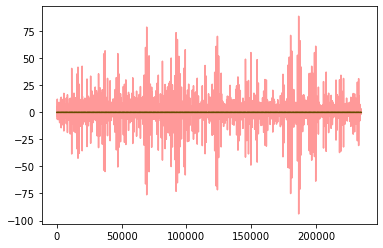

In [ ]:
# glm = sglm.GLM('Normal', verbose=False, alpha=0.05,
#             max_iter=10000, learning_rate=2e-8, score_metric='pseudo_R2',
#             reg_lambda=1e-100, eta=0)
glm = sglm.GLM('Normal', reg_lambda=0, alpha=0.5)
glm.fit(np.float64(X.values[1:, 4:5]), np.float64(y.values[1:]))

print('Example Predictions:', glm.model.predict(X.values[1:, 4:5]))

# plt.plot(pred[:1000], color='g')
# plt.plot(true[:1000], alpha = 0.4, color='r')
plt.plot(glm.model.predict(X.values[1:, 4:5]), color='g')
plt.plot(y.values[1:], alpha = 0.4, color='r')


In [ ]:

plt.plot(glm.model.predict(X.values), color='g')
plt.plot(y.values, alpha = 0.4, color='r')


ValueError: shapes (234921,82) and (1,) not aligned: 82 (dim 1) != 1 (dim 0)

In [149]:
df

[autoreload of sglm failed: Traceback (most recent call last):
  File "/Users/josh/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/josh/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/josh/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/josh/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/josh/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/josh/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new

      grnL grnL_diff
0  921.938       NaN
1  950.588   28.6499
2  944.091  -6.49645
3  948.262   4.17076
4  945.385  -2.87732
        nTrial  iBlock  CuePenalty  ENLPenalty  Select  Consumption  \
0          4.0     1.0         0.0         0.0     0.0          0.0   
1          4.0     1.0         0.0         0.0     0.0          0.0   
2          4.0     1.0         0.0         0.0     0.0          0.0   
3          4.0     1.0         0.0         0.0     0.0          0.0   
4          4.0     1.0         0.0         0.0     0.0          0.0   
...        ...     ...         ...         ...     ...          ...   
234923   239.0    13.0         0.0         0.0     0.0          0.0   
234924   239.0    13.0         0.0         0.0     0.0          0.0   
234925   239.0    13.0         0.0         0.0     0.0          0.0   
234926   239.0    13.0         0.0         0.0     0.0          0.0   
234927   239.0    13.0         0.0         0.0     0.0          0.0   

        responseTime 

In [ ]:
X.values[:, 0]

array([  4.,   4.,   4., ..., 239., 239., 239.])

In [148]:
# import cProfile
# import example_run_4
# cProfile.run('example_run_4.to_profile()')

KeyboardInterrupt: 

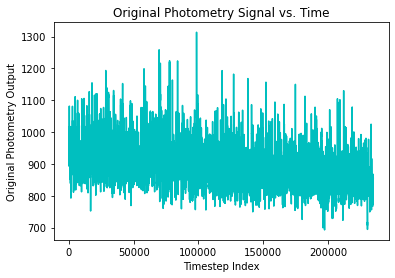

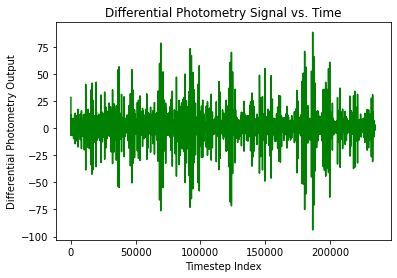

here


/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


In [147]:
print('here')